In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.style.use('tableau-colorblind10')

In [2]:
from IPython.display import display, Markdown
from databoost.scenario import SCENARIOS
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.inspection import permutation_importance
import warnings

METRICS = [roc_auc_score, brier_score_loss]

best_result = []
importances = {}
for scenario in SCENARIOS:
    s = SCENARIOS[scenario]
    train_X, test_X, train_y, test_y = s.train_test(legacy_size=0.0, legacy_drop_frac=0.0, legacy_missing_label=0.0)
    base_pipe = s.build_pipeline(train_X)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_pipe.fit(train_X, train_y)
        base_scored = base_pipe.predict_proba(test_X)[:,1]
        imp = permutation_importance(base_pipe, train_X, train_y, max_samples=1000)
        importances[scenario] = pd.DataFrame({
            'column': list(test_X.columns),
            'importance': np.abs(imp['importances_mean']),
        })
        
    row_result = {
        'scenario': scenario,
        'train_rows': len(train_y),
        'test_rows': len(test_y),
    }
    for metric in METRICS:
        row_result[str(metric.__name__)] = metric(test_y, base_scored)

    best_result.append(row_result)
    


display(Markdown("""# Best possible performance

This is what would be obtainable if we had no data loss.
"""))

best_result = pd.DataFrame(best_result)
best_result

# Best possible performance

This is what would be obtainable if we had no data loss.


,scenario,train_rows,test_rows,roc_auc_score,brier_score_loss
0,santander,28507,9503,0.816830,0.032872
1,car_insurance,43944,14648,0.649671,0.059832
2,tabular_playground,19927,6643,0.573514,0.170877
3,synthetic_1,75000,25000,0.932896,0.025190
4,synthetic_2_dataset_shift,75000,25000,0.886555,0.033067
5,cover_type_dataset_shift,435759,145253,0.990271,0.025968


In [3]:
from databoost.utils import SummedPredictors

# Data boosting

This model uses adaboost-style weights to build a second model that corrects the first one. The final model is merely the sum of the two.

In [4]:
from scipy.special import xlogy

def adaboost_weights(estimator, X, y, learning_rate=0.5, sample_weight=None):
    """Implement weights for a single boost using the SAMME.R real algorithm."""

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_predict_proba = estimator.predict_proba(X)
    if sample_weight is None:
        sample_weight = np.ones(shape=y.shape) / len(y)

    n_classes = 2
    classes = np.array([0,1])
    y_codes = np.array([-1.0 / (n_classes - 1), 1.0])
    y_coding = y_codes.take(classes == y[:, np.newaxis])

    # Displace zero probabilities so the log is defined.
    # Also fix negative elements which may occur with
    # negative sample weights.
    proba = y_predict_proba  # alias for readability
    np.clip(proba, np.finfo(proba.dtype).eps, None, out=proba)

    # Boost weight using multi-class AdaBoost SAMME.R alg
    estimator_weight = (
        -1.0
        * learning_rate
        * ((n_classes - 1.0) / n_classes)
        * xlogy(y_coding, y_predict_proba).sum(axis=1)
    )

    # Only boost positive weights
    sample_weight *= np.exp(
        estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
    )

    return sample_weight


def databoosted_pipe(train_X, train_y, scenario):
    old_idx = (train_X['legacy'] == 1)

    pipe1 = scenario.build_pipeline(train_X[old_idx])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pipe1.fit(
            train_X[old_idx], 
            train_y[old_idx], 
        )

    sample_weight = adaboost_weights(
        pipe1, train_X[~old_idx].copy(), 
        train_y[~old_idx].copy(), 
        learning_rate=0.25,
        sample_weight=scenario.base_sample_weight(train_X[~old_idx], train_y[~old_idx]),
    )

    pipe2 = scenario.build_pipeline(train_X[~old_idx])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pipe2.fit(train_X[~old_idx], train_y[~old_idx], final_estimator__sample_weight=sample_weight)

    boosted_pipe = SummedPredictors([pipe1, pipe2], [1.0, 1.0])
    return boosted_pipe

Text(0.5, 0, 'fpr')

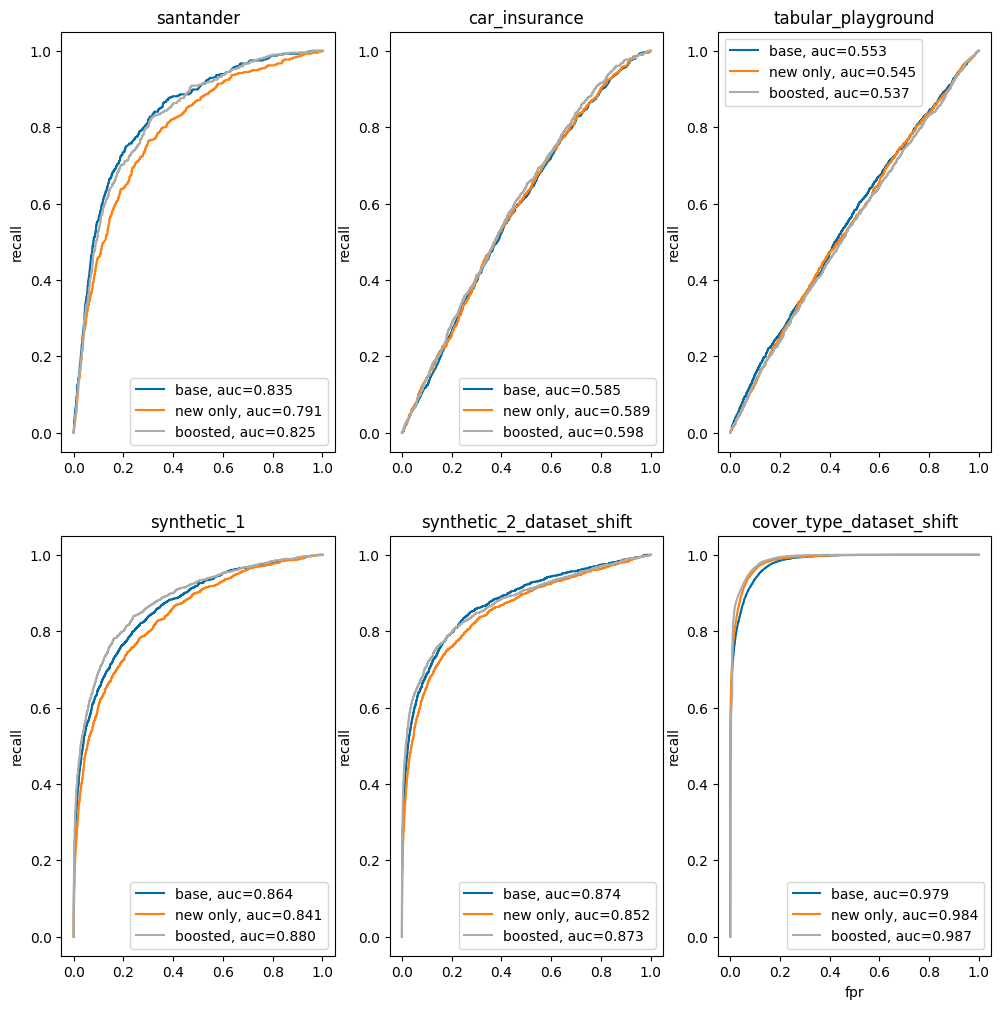

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    
    s = SCENARIOS[scenario]
    train_X, test_X, train_y, test_y = s.train_test(legacy_size=0.85, legacy_drop_frac=0.4, legacy_missing_label=0.0)
    base_pipe = s.build_pipeline(train_X)
    new_idx = ~(train_X['legacy'].astype(bool))
    new_only_pipe = s.build_pipeline(train_X[new_idx])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_pipe.fit(train_X, train_y)
        new_only_pipe.fit(train_X[new_idx], train_y[new_idx])
        bp = databoosted_pipe(train_X, train_y, s)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_scored = base_pipe.predict_proba(test_X)[:,1]
        new_only_scored = new_only_pipe.predict_proba(test_X)[:,1]
        boosted_scored = bp.predict_proba(test_X)[:,1]

    fpr, recall, _ = roc_curve(test_y, base_scored)
    plt.plot(fpr, recall, label='base, auc={:.3f}'.format(
        roc_auc_score(test_y, base_scored)
    ))
    fpr, recall, _ = roc_curve(test_y, new_only_scored)
    plt.plot(fpr, recall, label='new only, auc={:.3f}'.format(
        roc_auc_score(test_y, new_only_scored)
    ))
    fpr, recall, _ = roc_curve(test_y, boosted_scored)
    plt.plot(fpr, recall, label='boosted, auc={:.3f}'.format(
        roc_auc_score(test_y, boosted_scored)
    ))

    plt.title(scenario)
    plt.ylabel('recall')
    plt.legend()

plt.xlabel('fpr')


# Aggregate results

Let us now measure the benefit, across all datasets, and multiple parameter choices.

In what is seen below, `legacy_size` represents the fraction of the dataset that is missing features. This ranges from 10% to 95%,
and for each value of the parameter I do 5 iterations. Each iteration represents a different (randomly chosen) set of features
which get dropped on the legacy data set.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import itertools

result = []
iterations_per_scenario = 5

for scenario in SCENARIOS:
    for legacy_size, _ in itertools.product(np.arange(0.1, 1.0, 0.05), np.arange(iterations_per_scenario)):

        s = SCENARIOS[scenario]
        train_X, test_X, train_y, test_y = s.train_test(legacy_size=legacy_size, legacy_drop_frac=0.3, legacy_missing_label=0.0)
        base_pipe = s.build_pipeline(train_X)
        
        new_idx = ~(train_X['legacy'].astype(bool))
        new_only_pipe = s.build_pipeline(train_X[new_idx])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_pipe.fit(train_X, train_y)
            new_only_pipe.fit(train_X[new_idx], train_y[new_idx])
            bp = databoosted_pipe(train_X, train_y, s)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_scored = base_pipe.predict_proba(test_X)[:,1]
            new_only_scored = new_only_pipe.predict_proba(test_X)[:,1]
            boosted_scored = bp.predict_proba(test_X)[:,1]
            
        
        row_result = {'scenario': scenario, 'legacy_size': legacy_size}
        for max_fpr in [None]:
            if max_fpr is None:
                suffix = ''
            else:
                suffix = '_{}'.format(max_fpr)
            row_result['base_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, base_scored, max_fpr=max_fpr)
            row_result['boosted_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, boosted_scored, max_fpr=max_fpr)
            row_result['new_only_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, new_only_scored, max_fpr=max_fpr)
        
        row_result['deleted_importance'] = (
            pd.isnull(train_X[~new_idx]).all() @ importances[scenario].set_index('column')['importance']
        )
        result.append(row_result)

result = pd.DataFrame(result)


result = pd.merge(
    result,
    best_result[['scenario', 'roc_auc_score']].rename(columns={'roc_auc_score': 'full_data_auc_score'}),
    on='scenario',
    how='left'
)

result['boosted_regret'] = result['full_data_auc_score'] - result['boosted_roc_auc']
result['base_regret'] = result['full_data_auc_score'] - result['base_roc_auc']
result['new_only_regret'] = result['full_data_auc_score'] - result['new_only_roc_auc']
result['win_base'] = result['boosted_roc_auc'] > result['base_roc_auc']
result['win_new_only'] = result['boosted_roc_auc'] > result['new_only_roc_auc']
result['delta_base'] = result['boosted_roc_auc'] - result['base_roc_auc']
result['delta_new_only'] = result['boosted_roc_auc'] - result['new_only_roc_auc']
result['win_delta'] = (result['boosted_roc_auc'] - result['base_roc_auc'])*result['win_base']
result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
})

ValueError: Found unknown categories ['C20'] in column 0 during transform

In [ ]:
result['new_only_regret'] = result['full_data_auc_score'] - result['new_only_roc_auc']
result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
    'new_only_regret': 'mean',
})

## Dataset shift

Let me repeat the above experiment, but I'll impose an additional constraint on the data: on the legacy data, 20% of labels will be (wrongly)
set to zero.

In [ ]:
print(result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
#    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
    'new_only_regret': 'mean',
}).to_markdown(floatfmt=".3f"))

In [ ]:
result.columns

In [ ]:
scenario = 'car_insurance'
x = result[result['scenario'] == scenario]

plt.title("scenario={}".format(scenario))
plt.scatter(x['deleted_importance'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
plt.scatter(x['deleted_importance'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
plt.axhline(0, color='gray', alpha=0.5)
plt.legend()
plt.xlabel("Importance of censored features")
plt.ylabel("roc_auc(boosted) - roc_auc(base)")

plt.show()
x

In [ ]:
n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    x = result[result['scenario'] == scenario]

    plt.title("scenario={}".format(scenario))
    plt.scatter(x['legacy_size'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
    plt.scatter(x['legacy_size'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
    plt.axhline(0, color='gray', alpha=0.5)
    plt.legend()
    plt.xlabel("Fraction of old data")
    if (i % 3 == 2):
        plt.ylabel("roc_auc(boosted) - roc_auc(base)")


In [ ]:
n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    x = result[result['scenario'] == scenario]

    plt.title("scenario={}".format(scenario))
    plt.scatter(x['deleted_importance'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
    plt.scatter(x['deleted_importance'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
    plt.axhline(0, color='gray', alpha=0.5)
    plt.legend()
    plt.xlabel("Importance of deleted features")
    if (i % 3 == 2):
        plt.ylabel("roc_auc(boosted) - roc_auc(base)")


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import itertools

result = []
iterations_per_scenario = 5

for scenario in SCENARIOS:
    for legacy_drop_frac, _ in itertools.product(np.arange(0.1, 0.95, 0.05), np.arange(iterations_per_scenario)):

        s = SCENARIOS[scenario]
        train_X, test_X, train_y, test_y = s.train_test(legacy_size=0.85, legacy_drop_frac=legacy_drop_frac, legacy_missing_label=0.0)
        base_pipe = s.build_pipeline(train_X)
        
        new_idx = ~(train_X['legacy'].astype(bool))
        new_only_pipe = s.build_pipeline(train_X[new_idx])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_pipe.fit(train_X, train_y)
            new_only_pipe.fit(train_X[new_idx], train_y[new_idx])
            bp = databoosted_pipe(train_X, train_y, s)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_scored = base_pipe.predict_proba(test_X)[:,1]
            new_only_scored = new_only_pipe.predict_proba(test_X)[:,1]
            boosted_scored = bp.predict_proba(test_X)[:,1]
            
        
        row_result = {'scenario': scenario, 'legacy_drop_frac': legacy_drop_frac}
        for max_fpr in [None]:
            if max_fpr is None:
                suffix = ''
            else:
                suffix = '_{}'.format(max_fpr)
            row_result['base_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, base_scored, max_fpr=max_fpr)
            row_result['boosted_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, boosted_scored, max_fpr=max_fpr)
            row_result['new_only_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, new_only_scored, max_fpr=max_fpr)
        
        row_result['deleted_importance'] = (
            pd.isnull(train_X[~new_idx]).all() @ importances[scenario].set_index('column')['importance']
        )
        result.append(row_result)

result = pd.DataFrame(result)


result = pd.merge(
    result,
    best_result[['scenario', 'roc_auc_score']].rename(columns={'roc_auc_score': 'full_data_auc_score'}),
    on='scenario',
    how='left'
)

result['boosted_regret'] = result['full_data_auc_score'] - result['boosted_roc_auc']
result['base_regret'] = result['full_data_auc_score'] - result['base_roc_auc']
result['new_only_regret'] = result['full_data_auc_score'] - result['new_only_roc_auc']
result['win_base'] = result['boosted_roc_auc'] > result['base_roc_auc']
result['win_new_only'] = result['boosted_roc_auc'] > result['new_only_roc_auc']
result['delta_base'] = result['boosted_roc_auc'] - result['base_roc_auc']
result['delta_new_only'] = result['boosted_roc_auc'] - result['new_only_roc_auc']
result['win_delta'] = (result['boosted_roc_auc'] - result['base_roc_auc'])*result['win_base']
result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
})

In [ ]:
n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    x = result[result['scenario'] == scenario]

    plt.title("scenario={}".format(scenario))
    plt.scatter(x['deleted_importance'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
    plt.scatter(x['deleted_importance'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
    plt.axhline(0, color='gray', alpha=0.5)
    plt.legend()
    plt.xlabel("Importance of deleted features")
    if (i % 3 == 2):
        plt.ylabel("roc_auc(boosted) - roc_auc(base)")
